<a href="https://colab.research.google.com/github/rahiakela/computer-vision-video-analytics/blob/master/video_classification_with_keras_and_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video classification with Keras and Deep Learning

In this tutorial, you will learn how to perform video classification using Keras, Python, and Deep Learning.

Specifically, you will learn:

- The difference between video classification and standard image classification
- How to train a Convolutional Neural Network using Keras for image classification
- How to take that CNN and then use it for video classification
- How to use **rolling prediction averaging to reduce “flickering” in results**

This tutorial will serve as an introduction to the concept of working with deep learning in a temporal nature, paving the way for when we discuss Long Short-term Memory networks (LSTMs) and eventually human activity recognition.

## Overview

Videos can be understood as a series of individual images; and therefore, many deep learning practitioners would be quick to treat video classification as performing image classification a total of N times, where N is the total number of frames in a video.

**There’s a problem with that approach though.**

Video classification is more than just simple image classification — **with video we can typically make the assumption that subsequent frames in a video are correlated with respect to their semantic contents.**

If we are able to take advantage of the temporal nature of videos, we can improve our actual video classification results.

Neural network architectures such as Long short-term memory (LSTMs) and Recurrent Neural Networks (RNNs) are suited for time series data — two topics that we’ll be covering in later tutorials — but in some cases, they may be overkill. They are also resource-hungry and time-consuming when it comes to training over thousands of video files as you can imagine.

**Instead, for some applications, all you may need is rolling averaging over predictions.**

In the remainder of this tutorial, you’ll learn how to train a CNN for image classification (specifically sports classification) and then turn it into a more accurate video classifier by employing rolling averaging.

### How is video classification different than image classification?

When performing image classification, we:

1. Input an image to our CNN
2. Obtain the predictions from the CNN
3. Choose the label with the largest corresponding probability

Since a video is just a series of frames, a naive video classification method would be to:

1. Loop over all frames in the video file
2. For each frame, pass the frame through the CNN
3. Classify each frame individually and independently of each other
4. Choose the label with the largest corresponding probability
5. Label the frame and write the output frame to disk

There’s a problem with this approach though — if you’ve ever tried to apply simple image classification to video classification you likely encountered a sort of “prediction flickering” [as seen in the video at the top of this section](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/). Notice how in this visualization we see our CNN shifting between two predictions: “football” and the correct label, “weight_lifting”.

The video is clearly of weightlifting and we would like our entire video to be labeled as such — but how we can prevent the CNN “flickering” between these two labels?

**A simple, yet elegant solution, is to utilize a rolling prediction average.**

Our algorithm now becomes:

1. Loop over all frames in the video file
2. For each frame, pass the frame through the CNN
3. Obtain the predictions from the CNN
4. Maintain a list of the last K predictions
5. Compute the average of the last K predictions and choose the label with the largest corresponding probability
6. Label the frame and write the output frame to disk

The results of this algorithm can be seen in the video at the very top of this post — notice how the prediction flickering is gone and the entire video clip is correctly labeled!



### The Sports Classification Dataset

<img src='https://pyimagesearch.com/wp-content/uploads/2019/07/keras_video_classification_sports_dataset.jpg?raw=1' width='800'/>

The dataset we’ll be using here today is for sport/activity classification. The dataset was curated by [Anubhav Maity](https://github.com/anubhavmaity) by downloading photos from [Google Images (you could also use Bing)](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/) for the following categories:

<img src='https://github.com/rahiakela/img-repo/blob/master/listing.png?raw=1' width='800'/>

To save time, computational resources, and to demonstrate the actual video classification algorithm (the actual point of this tutorial), we’ll be training on a subset of the sports type dataset:

- **Football** (i.e., soccer): 799 images
- **Tennis**: 718 images
- **Weightlifting**: 577 images

Let’s go ahead and download our dataset!

### Downloading the Sports Classification Dataset

I’ve decided to include a subset of the dataset because Anubhav Maity’s original dataset is no longer available on GitHub (a near-identical sports dataset is available [here](https://github.com/jurjsorinliviu/Sports-Type-Classifier)).



In [1]:
# download dataset from github
!git clone https://github.com/jurjsorinliviu/Sports-Type-Classifier

Cloning into 'Sports-Type-Classifier'...
remote: Enumerating objects: 14521, done.
remote: Total 14521 (delta 0), reused 0 (delta 0), pack-reused 14521
Receiving objects: 100% (14521/14521), 592.88 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (14619/14619), done.


In [2]:
# creating directory for subset of dataset
!mkdir sports-type-classifier
!mkdir sports-type-classifier/data
!mkdir sports-type-classifier/data/football
!mkdir sports-type-classifier/data/tennis
!mkdir sports-type-classifier/data/weightlifting

# copy the subset of dataset(Football, Tennis and Weightlifting)
! cp Sports-Type-Classifier/data/football/* sports-type-classifier/data/football
! cp Sports-Type-Classifier/data/tennis/* sports-type-classifier/data/tennis
! cp Sports-Type-Classifier/data/weight_lifting/* sports-type-classifier/data/weightlifting

In [3]:
!ls sports-type-classifier/data | grep -Ev "urls|models|csv|pkl"

football
tennis
weightlifting


## Implementing video classification

We have divided the implementation into two section:

- **Training Keras model**: that grabs the dataset class images that we care about,[ loads the ResNet50 CNN, and applies transfer learning](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)/fine-tuning of ImageNet weights to train our model. The training script generates/outputs three files:
  - `model/activity.model` : A fine-tuned classifier based on ResNet50 for recognizing sports.
  - `model/lb.pickle` : A serialized label binarizer containing our unique class labels.
  - `plot.png` : The accuracy/loss training history plot.

- **Predicting**: Loads an input video from the example_clips/ and proceeds to classify the video ideally using today’s rolling average method.


### Training Keras model

Let’s go ahead and train a Keras CNN to recognize each of the sports activities.

In [21]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

%matplotlib inline

Let’s proceed to initialize our LABELS and load our data :

The set of class LABELS for which our dataset will consist of. All labels not present in this set will be excluded from being part of our dataset. To save on training time, our dataset will only consist of weight lifting, tennis, and football/soccer. Feel free to work with other classes by making changes to the LABELS set.

In [5]:
# initialize the set of labels from the spots activity dataset we are going to train our network on
LABELS = set(["weightlifting", "tennis", "football"])

Load and preprocess an image . Preprocessing includes swapping color channels for OpenCV to Keras compatibility and resizing to 224×224px.

In [6]:
image_paths = "sports-type-classifier/data"
data = []
labels = []

# loop over the image paths
for entry in os.scandir(image_paths):
  img_path = entry.path
  # extract the class label from the filename
  label = img_path.split(os.path.sep)[-1]
  # if the label of the current image is not part of of the labels are interested in, then ignore the image
  if label not in LABELS:
    continue

  for filename in os.listdir(entry.path):
    # load the image, convert it to RGB channel ordering, and resize it to be a fixed 224x224 pixels, ignoring aspect ratio
    if filename.endswith(".jpg"):
      image = cv2.imread(os.path.join(img_path, filename))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))

      # update the data and labels lists, respectively
      data.append(image)
      labels.append(label)
print(len(data), len(labels))

1779 1779


One-hot encoding is a way of marking an active class label via binary array elements. For example “football” may be array([1, 0, 0]) whereas “weightlifting” may be array([0, 0, 1]) . Notice how only one class is “hot” at any given time.

In [7]:
# convert the data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print(labels.shape)
print(data.shape)

# perform one-hot encoding on the labels
label_encoder = LabelBinarizer()
labels = label_encoder.fit_transform(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
# (trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
trainX = data[:1200]
testX = data[1200:]
trainY = labels[:1200]
testY = labels[1200:]
print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

(1779,)
(1779, 224, 224, 3)
(1200, 224, 224, 3) (579, 224, 224, 3)
(1200, 3) (579, 3)


Let's initialize two data augmentation objects — one for training and one for validation. Data augmentation is nearly always recommended in deep learning for computer vision to increase model generalization.

The trainAug object performs random rotations, zooms, shifts, shears, and flips on our data. You can [read more about the ImageDataGenerator and fit here](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/). As we reinforced last week, keep in mind that [with Keras, images will be generated on-the-fly](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/) (it is not an additive operation).

No augmentation will be conducted for validation data (valAug ), but we will perform mean subtraction.

In [8]:
# initialize the training data augmentation object
train_aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which we'll be adding mean subtraction to)
val_aug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_aug.mean = mean
val_aug.mean = mean

Now we’re going to perform what I like to call “network surgery” as part of fine-tuning:

In [9]:
# load the ResNet-50 network, ensuring the head FC layer sets are left off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(label_encoder.classes_), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


Let’s go ahead and compile + train our model

In [10]:
# compile our model (this needs to be done after our setting our layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=train_aug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=val_aug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=50)

[INFO] compiling model...
[INFO] training head...
Epoch 1/50
37/37 [==============================] - 15s 392ms/step - loss: 1.2313 - accuracy: 0.5009 - val_loss: 3.4295 - val_accuracy: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 14s 371ms/step - loss: 0.8149 - accuracy: 0.6592 - val_loss: 2.6547 - val_accuracy: 0.0069
Epoch 3/50
37/37 [==============================] - 14s 372ms/step - loss: 0.6801 - accuracy: 0.7269 - val_loss: 2.2893 - val_accuracy: 0.0243
Epoch 4/50
37/37 [==============================] - 14s 372ms/step - loss: 0.6304 - accuracy: 0.7466 - val_loss: 2.0748 - val_accuracy: 0.0556
Epoch 5/50
37/37 [==============================] - 14s 371ms/step - loss: 0.5269 - accuracy: 0.7928 - val_loss: 1.9384 - val_accuracy: 0.0799
Epoch 6/50
37/37 [==============================] - 14s 375ms/step - loss: 0.4772 - accuracy: 0.8202 - val_loss: 1.5850 - val_accuracy: 0.2101
Epoch 7/50
37/37 [==============================] - 14s 373ms/step - loss: 0.4569 - accu

We’ll begin to wrap up by evaluating our network and plotting the training history:

In [13]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=label_encoder.classes_))

[INFO] evaluating network...
               precision    recall  f1-score   support

     football       1.00      0.78      0.88       579
       tennis       0.00      0.00      0.00         0
weightlifting       0.00      0.00      0.00         0

     accuracy                           0.78       579
    macro avg       0.33      0.26      0.29       579
 weighted avg       1.00      0.78      0.88       579



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
!mkdir model
!mkdir output

mkdir: cannot create directory ‘model’: File exists


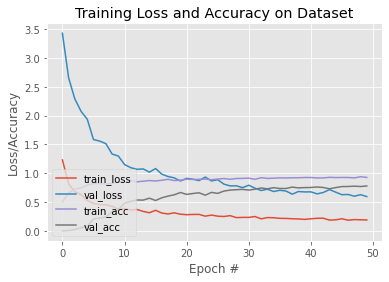

In [22]:
# plot the training loss and accuracy
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save("model/activity.model", save_format="h5")

# serialize the label binarizer to disk
f = open("output/lb.pickle", "wb")
f.write(pickle.dumps(label_encoder))
f.close()

As you can see, we’re obtaining ~94% accuracy after fine-tuning ResNet50 on the sports dataset.

### Video classification with Keras and rolling prediction averaging

We are now ready to implement video classification with Keras via rolling prediction accuracy!

**To create this script we’ll take advantage of the temporal nature of videos, specifically the assumption that subsequent frames in a video will have similar semantic contents.**

By performing rolling prediction accuracy we’ll be able to “smoothen out” the predictions and avoid “prediction flickering”.

Now let's do some predition.